In [60]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt
import ast
import matplotlib.pyplot as plt

In [38]:
df = pd.read_csv(r'C:\Users\rodge\OneDrive\Desktop\SML\Group Project\comp90051\data\rawData\processedData\waveform_decode_data\56524d7755da9372.csv')

In [39]:
ART = df[df['mg_name'] == 'GE_ART'].reset_index(drop=True)
ART.loc[:,'binwave'] = ART['binwave'].apply(lambda x: np.array(ast.literal_eval(x)))

def statistical_ART(signal): 
    return {
        'mean'  :np.mean(signal),
        'std'   :np.std(signal),
        'max'   :np.max(signal),
        'min'   :np.min(signal),
        'range' :np.ptp(signal),
        'skewness':skew(signal),
        'kurtosis':kurtosis(signal),
        'variance':np.var(signal)
    }

ART_matrix = np.array([list(statistical_ART(row).values()) for row in ART['binwave']])
U, S, Vt = np.linalg.svd(ART_matrix, full_matrices=False)
print('Singular Values:', S)


Singular Values: [2.04160996e+07 3.63719897e+04 3.66588168e+03 1.86716232e+03
 4.76947397e+02 3.95839483e+02 1.00808896e+01 1.66300153e-11]


In [40]:
ART_matrix

array([[ 3.54444444e+00,  8.16987843e-01,  5.00000000e+00, ...,
        -7.89943380e-02, -9.06986220e-01,  6.67469136e-01],
       [ 3.55694444e+00,  6.40003557e-01,  4.75000000e+00, ...,
        -8.12030045e-02, -8.64120962e-01,  4.09604552e-01],
       [ 3.54722222e+00,  5.46319052e-01,  4.50000000e+00, ...,
        -1.74778834e-01, -1.08670191e+00,  2.98464506e-01],
       ...,
       [ 3.60972222e+00,  3.37455387e+00,  8.00000000e+00, ...,
        -1.95632409e-03, -1.89674156e+00,  1.13876138e+01],
       [ 3.59722222e+00,  2.91564135e+00,  7.50000000e+00, ...,
        -3.71176320e-03, -1.84228906e+00,  8.50096451e+00],
       [ 3.63194444e+00,  2.70036399e+00,  7.25000000e+00, ...,
        -1.78463163e-03, -1.83236147e+00,  7.29196566e+00]])

In [41]:
ECG = df[df['mg_name'] == 'GE_ECG'].reset_index(drop=True)
ECG.loc[:,'binwave'] = ECG['binwave'].apply(lambda x: np.array(ast.literal_eval(x)))

# Extract features from ECG signal using FFT
def featureExtraction_fft(signal, rate_hz):
    
    fft_transfer = fft(signal)
    magnitude = np.abs(fft_transfer)
    phase = np.angle(fft_transfer)

    freq_resolution = rate_hz / len(signal)

    low_freq_range = (0.5, 10)
    qrs_freq_range = (10, 50)
    high_freq_range = (50, rate_hz/2)

    low_freq_indices = np.floor(np.array(low_freq_range) / freq_resolution).astype(int)
    qrs_freq_indices = np.floor(np.array(qrs_freq_range) / freq_resolution).astype(int)
    high_freq_indices = np.floor(np.array(high_freq_range) / freq_resolution).astype(int)

    low_freq_power = np.sum(magnitude[low_freq_indices[0]:low_freq_indices[1]])
    qrs_freq_power = np.sum(magnitude[qrs_freq_indices[0]:qrs_freq_indices[1]])
    high_freq_power = np.sum(magnitude[high_freq_indices[0]:high_freq_indices[1]])
    peak_freq = np.argmax(magnitude[1:]) * freq_resolution  # Frequency with highest magnitude

    peaks, _ = find_peaks(magnitude)
    num_peaks = len(peaks)
    rate_hz = rate_hz

    return {
        'low_freq_power': low_freq_power,
        'qrs_freq_power': qrs_freq_power,
        'high_freq_power': high_freq_power,
        'peak_freq': peak_freq,
        'num_peaks': num_peaks,
        'mean_magnitude': np.mean(magnitude),
        'std_magnitude': np.std(magnitude),
        'mean_phase': np.mean(phase),
        'std_phase': np.std(phase),
        'skewness_magnitude': skew(magnitude),
        'kurtosis_magnitude': kurtosis(magnitude),
        'rate_hz':  rate_hz
    }


feature_names = ['low_freq_power', 'qrs_freq_power', 'high_freq_power', 'peak_freq', 'num_peaks', 
                 'mean_magnitude', 'std_magnitude', 'mean_phase', 'std_phase', 
                 'skewness_magnitude', 'kurtosis_magnitude','rate_hz']

fft_result = []

#extract features from each ECG signal
for i in range(len(ECG)):
    signal = ECG['binwave'][i]
    rate_hz = ECG['hz'][i]
    feature_result = featureExtraction_fft(signal, rate_hz)
    fft_result.append([feature_result[name] for name in feature_names])

#transform the result into a dataframe for visualization
ECG_df = pd.DataFrame(fft_result, columns=feature_names)

#drop the rate_hz column
ECG_matrix = np.array(fft_result)[:,:-1]

#tranform the matrix into a singular value decomposition for model training
U, S, Vt = np.linalg.svd(ECG_matrix, full_matrices=False)
print('Singular Values:', S)




Singular Values: [6.72231231e+06 4.25749459e+06 6.52622873e+05 1.58688826e+05
 3.38101272e+04 5.80314531e+03 4.17075096e+03 1.46806719e+03
 8.28799290e+01 6.21713501e+01 2.90965537e+00]


In [42]:
ECG_df

,low_freq_power,qrs_freq_power,high_freq_power,peak_freq,num_peaks,mean_magnitude,std_magnitude,mean_phase,std_phase,skewness_magnitude,kurtosis_magnitude,rate_hz
0,2359.829436,403.547132,739.461799,89.0,55,33.731537,193.166207,3.947460e-17,1.966087,10.035701,104.270991,180
1,2317.522998,394.329881,642.476748,89.0,59,32.370329,193.349843,0.000000e+00,1.835386,9.916863,101.639673,180
2,2321.833908,369.471680,700.868781,89.0,53,33.001937,196.053238,4.934325e-18,1.901951,9.857561,100.002194,180
3,2348.287607,370.440776,662.722072,89.0,61,32.927227,197.346897,-9.868649e-18,1.771170,9.846921,99.624512,180
4,2332.435589,440.552174,613.215666,89.0,65,33.280038,198.732079,3.947460e-17,1.803690,9.747773,97.312361,180
...,...,...,...,...,...,...,...,...,...,...,...,...
111317,2297.386151,390.211546,1320.126659,89.0,51,39.296937,190.519686,-1.745329e-02,1.299716,9.897446,102.709823,180
111318,2327.760160,442.953656,1067.244866,89.0,53,43.388430,239.400176,-1.745329e-02,1.641122,9.206632,83.634135,180
111319,2301.690705,350.947753,997.757269,89.0,45,43.526619,260.715234,-1.745329e-02,1.697027,9.394549,87.869141,180
111320,2317.558520,386.219736,940.172301,89.0,53,45.566117,284.627351,-1.745329e-02,1.848536,9.646222,93.884519,180


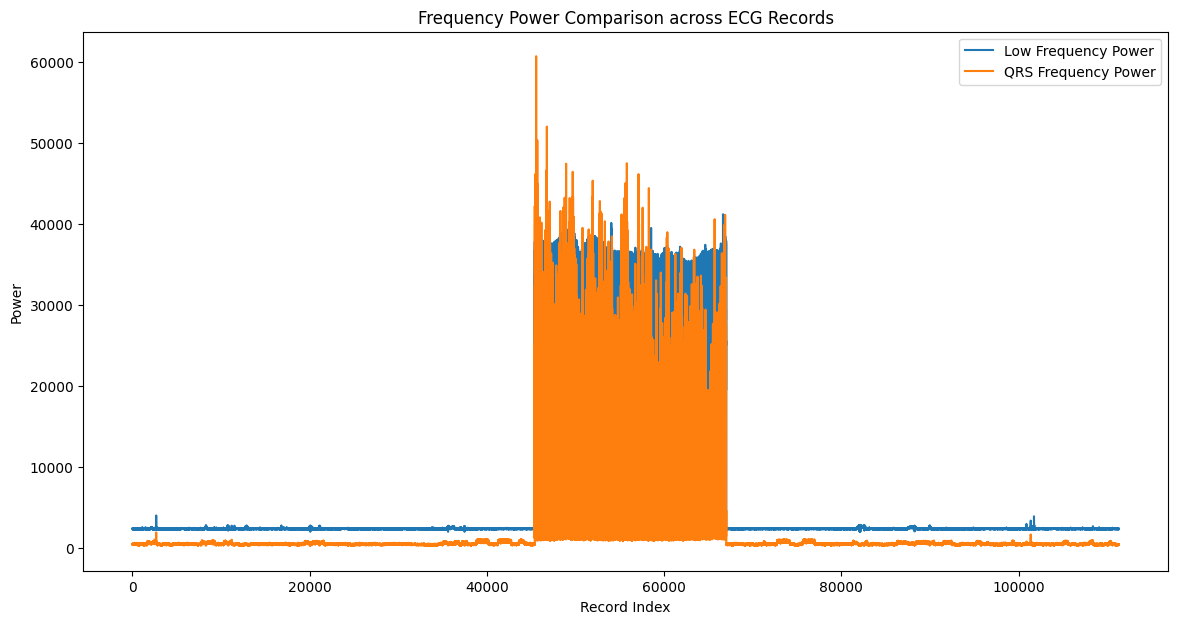

In [43]:
# Plot the frequency power comparison across ECG records

plt.figure(figsize=(14, 7))
plt.plot(ECG_df['low_freq_power'], label='Low Frequency Power')
plt.plot(ECG_df['qrs_freq_power'], label='QRS Frequency Power')
# plt.plot(ECG_df['high_freq_power'], label='High Frequency Power')
plt.title('Frequency Power Comparison across ECG Records')
plt.xlabel('Record Index')
plt.ylabel('Power')
plt.legend()
plt.show()


In [56]:
df = ECG.copy()

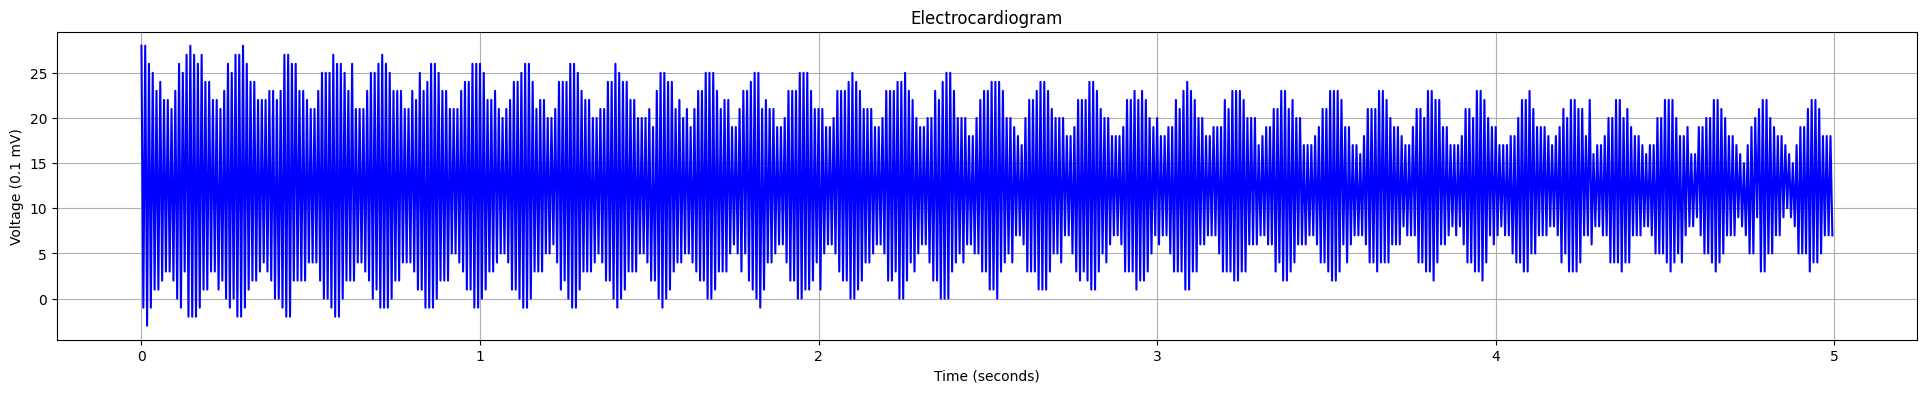

In [59]:
start_second = 111308
end_second = 111312

# 将选定时间段的数据转换为一个单一的列表
data_to_plot = []
for second in range(start_second, end_second + 1):
    data_to_plot.extend(df['binwave'].iloc[second - 1])

# 创建时间轴，因为每秒有180个点
time_axis = [t / 180 for t in range(len(data_to_plot))]

# 绘制心电图
plt.figure(figsize=(24, 4))
plt.plot(time_axis, data_to_plot, color='blue')
plt.title('Electrocardiogram')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (0.1 mV)')
plt.grid(True)
plt.show()

In [54]:
df = ECG['binwave']
df

0         [17.0, 7.0, 18.0, 4.0, 21.0, 3.0, 20.0, 3.0, 2...
1         [21.0, 4.0, 22.0, 3.0, 23.0, 3.0, 22.0, 4.0, 1...
2         [21.0, 3.0, 23.0, 2.0, 23.0, 3.0, 22.0, 6.0, 1...
3         [23.0, 2.0, 23.0, 5.0, 20.0, 6.0, 20.0, 6.0, 1...
4         [21.0, 4.0, 23.0, 2.0, 22.0, 3.0, 20.0, 6.0, 2...
                                ...                        
111317    [10.0, 17.0, 8.0, 17.0, 8.0, 17.0, 8.0, 19.0, ...
111318    [1.0, 25.0, -1.0, 26.0, 0.0, 26.0, 0.0, 25.0, ...
111319    [-1.0, 25.0, -1.0, 23.0, 1.0, 24.0, 1.0, 25.0,...
111320    [-6.0, 30.0, -5.0, 31.0, -5.0, 31.0, -7.0, 32....
111321    [-5.0, 30.0, -7.0, 28.0, -3.0, 27.0, -3.0, 28....
Name: binwave, Length: 111322, dtype: object

In [ ]:
file_path = r'C:\Users\rodge\OneDrive\Desktop\SML\Group Project\comp90051\data\rawData\unzip_file\\'
post_op = 'patient_post_op_complications.csv'

post_op =pd.read_csv(os.path.join(file_path, post_op))